In [1]:
import pathlib
import sys

script_dir = pathlib.Path().parent.absolute()
parent_dir = script_dir.parents[0]
sys.path.append(str(parent_dir))

import xarray as xr
import os
from labsea_project import utilities, plotters, tools, writers
from labsea_project import reference_func as ref
import numpy as np
import matplotlib.pyplot as plt
import gsw
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, Normalize
import cmocean
import scipy


#suppress syntax warnings
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)


In [2]:
xstart, xend = 200, 860
case = '0413_mayjunjul'
file_case = '2004_to_2023_1000db_isobars'
omega = 30.0
ds_opt1 = writers.create_dataset(case, file_case, omega, xstart, xend, spacing_z=25, spacing_x=10, mask_sigma=True)
ds_opt1

season: mayjunjul
cut_season: True


<xarray.Dataset> Size: 263kB
Dimensions:       (z: 81, x: 67, xhalf: 66)
Coordinates:
  * x             (x) int64 536B 200 210 220 230 240 250 ... 820 830 840 850 860
  * z             (z) int64 648B 0 -25 -50 -75 -100 ... -1925 -1950 -1975 -2000
  * xhalf         (xhalf) float64 528B 205.0 215.0 225.0 ... 835.0 845.0 855.0
Data variables:
    specvol_anom  (z, x) float64 43kB 1.317e-06 1.228e-06 ... 4.098e-07
    sigma0        (z, x) float64 43kB 26.72 26.81 26.92 ... 27.83 27.83 27.83
    SA            (z, x) float64 43kB 33.96 34.08 34.21 ... 35.08 35.07 35.07
    CT            (z, x) float64 43kB 5.223 5.088 4.95 ... 2.85 2.848 2.841
    v             (z, xhalf) float64 43kB -0.2288 -0.185 -0.1355 ... nan nan nan
    sigma0half    (z, xhalf) float64 43kB 26.77 26.87 26.96 ... nan nan nan
    strf_z        (z) float64 648B 0.0 0.1083 0.2235 0.3371 ... 4.328 4.312 4.31
    strf_x        (xhalf) float64 528B 0.0 -3.241 -5.722 ... -4.786 -0.5707
    mask_xa       (xhalf) bool 66B False False False False ... False False False
    argo_ref      (xhalf) float64 528B -0.2025 -0.1518 -0.1098 ... 0.2155 0.2847
    imbalance     float64 8B -0.5707
Attributes:
    description:  Weighted data for 0413_mayjunjul with omega=30.0, xstart=20...
    units:        {'specvol_anom (specific volume anomaly)': 'kg/m^3 \n', 'si...

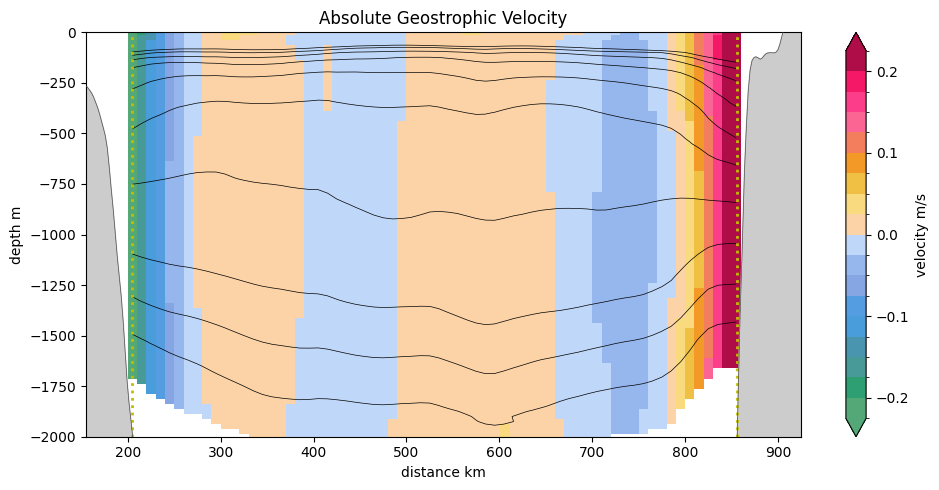

In [3]:
plotters.plot_abs_geo_v(ds_opt1, "Absolute Geostrophic Velocity", "xstart200_depth_space", saving=False)

In [4]:
# calc adujustment to balance transport in depth space
v = ds_opt1['v'].values.copy()
xhalf = ds_opt1['xhalf'].values*1e3 # in m
z = ds_opt1['z'].values*-1 # positive z to calc. transport
sigma0half = ds_opt1['sigma0half'].values.copy()

# barotropic adj.
c0 = tools.find_adjustment_velocity(v, xhalf, z, onlyEast=False)
strf_z_adj0, strf_x__adj0, imbalance_adj0, mask_xa_adj0 = tools.derive_strf(v, xhalf, z, sensitivity=c0, onlyEast=False)
ds_opt1['c0'] = c0

# adj. at eastern edge
c_east = tools.find_adjustment_velocity(v, xhalf, z, onlyEast=True)
ds_opt1['c_east'] = c_east

# derive transport in density space
step = 0.005
sigma_bins = np.linspace(27.2, 27.8, np.int64((27.8-27.2)/step)+1)

# default: no adj.
Q0_opt1, Q_opt1 = tools.derive_transport_in_density_space(v, sigma0half, sigma_bins)
Q0_opt1_adj, Q_opt1_adj = tools.derive_transport_in_density_space(v, sigma0half, sigma_bins, sensitivity=c0)    
Q0_opt1_east, Q_opt1_east = tools.derive_transport_in_density_space(v, sigma0half, sigma_bins, sensitivity=c_east, onlyEast=True)



Adjustment velocity of -0.003361 m/s determined at 4e-05 Sv vertical imbalance
Adjustment velocity of -0.02394 m/s determined at 0.000309 Sv vertical imbalance


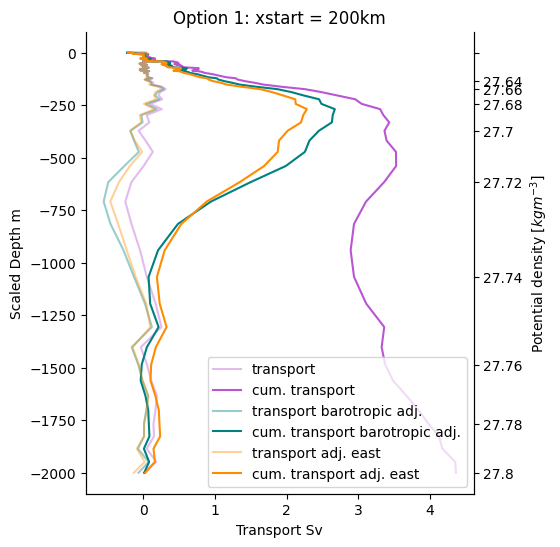

In [6]:
mean_sigma0 = np.load(parent_dir / f"data/mean_sigma0_2004_to_2023_1000db_isobars_all_data_omega{int(omega)}_xstart{int(xstart)}_xend{int(xend)}.npy")
scaled_depth = np.interp(sigma_bins, mean_sigma0, z*-1)

fig, ax = plt.subplots(1,1,figsize=(5, 6))
ax.plot( Q0_opt1, scaled_depth, linestyle='-', color='mediumorchid', label='transport', alpha=0.4)
ax.plot( Q_opt1, scaled_depth, color='mediumorchid', label='cum. transport')

ax.plot( Q0_opt1_adj, scaled_depth, linestyle='-', color='teal', label='transport barotropic adj.', alpha=0.4)
ax.plot( Q_opt1_adj, scaled_depth, color='teal', label='cum. transport barotropic adj.')

ax.plot( Q0_opt1_east, scaled_depth, linestyle='-', color='darkorange', label='transport adj. east', alpha=0.4)
ax.plot( Q_opt1_east, scaled_depth, color='darkorange', label='cum. transport adj. east')

ax.legend()

densities = [27.64, 27.66, 27.68, 27.7, 27.72, 27.74, 27.76, 27.78, 27.8]

ints  = [np.argmin(abs(sigma_bins - densities[i])) for i in range(len(densities))] 

z_ticks   = scaled_depth[ints]
z_ticks = np.insert(z_ticks, 0, 0)

dens_ticks = ['']
dens_ticks.extend([f'{density}' for density in densities])
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(z_ticks)
ax2.set_yticklabels(dens_ticks)
ax2.set_ylabel(r'Potential density [$kg m^{-3}$]')

ax.set_xlabel('Transport Sv')
ax.set_ylabel( 'Scaled Depth m')

plt.title('Option 1: xstart = 200km')

# make axis invisible
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.savefig(parent_dir / f"figures/density_transport_option1_xstart{xstart}_xend{xend}_omega{int(omega)}.png", dpi=300, bbox_inches='tight')
plt.show()
